In [4]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import argparse
import cv2

In [27]:
class ConvAutoencoder:
    @staticmethod
    def build(w, h, d, filters=(32,64), latentDim=16):
        inputShape = (h,w,d)
        chanDim = -1
        
        inputs = Input(shape = inputShape)
        x = inputs
        
        for f in filters:
            x = Conv2D(f, (3,3), strides=2, padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
            
        volumeSize = K.int_shape(x) # (None, h, w, d)

        x = Flatten()(x)
        latent = Dense(latentDim, name='encoded')(x)
        x = Dense(np.prod(volumeSize[1:]))(latent)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)
       
        x = Conv2DTranspose(d, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid", name="decoded")(x)
        
        autoencoder = Model(inputs, outputs, name="autoencoder")
        
        return autoencoder
            

In [28]:
# comparing original ground truth gt with the reconstructed image

def visualize_predictions(decoded, gt, samples = 10):
    outputs = None
    for i in range(samples):
        orig = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")
        
        output = np.hstack([orig, recon])
        
        if outputs is None:
            outputs = output
        else:
            outputs = np.vstack([outputs, output])
            
    return outputs
        

In [29]:
epochs = 20
lrate = 1e-3
batch_size = 32

print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [30]:
trainX.shape, testX.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [31]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=lrate, decay=lrate / epochs)
autoencoder.compile(loss="mse", optimizer=opt)
autoencoder.summary()

[INFO] building autoencoder...
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_______________________________________________________________

In [32]:
# train the convolutional autoencoder
H = autoencoder.fit( trainX, trainX, validation_data=(testX, testX),
                    epochs=epochs, batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
60000/60000 [==============================] - 650s 11ms/sample - loss: 0.0186 - val_loss: 0.0110
Epoch 2/20
60000/60000 [==============================] - 630s 11ms/sample - loss: 0.0103 - val_loss: 0.0100
Epoch 3/20
60000/60000 [==============================] - 501s 8ms/sample - loss: 0.0092 - val_loss: 0.0085
Epoch 4/20
60000/60000 [==============================] - 502s 8ms/sample - loss: 0.0086 - val_loss: 0.0081
Epoch 5/20
60000/60000 [==============================] - 502s 8ms/sample - loss: 0.0083 - val_loss: 0.0080
Epoch 6/20
60000/60000 [==============================] - 557s 9ms/sample - loss: 0.0079 - val_loss: 0.0077
Epoch 7/20
60000/60000 [==============================] - 533s 9ms/sample - loss: 0.0077 - val_loss: 0.0075
Epoch 8/20
60000/60000 [==============================] - 476s 8ms/sample - loss: 0.0075 - val_loss: 0.0076
Epoch 9/20
60000/60000 [============

In [34]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)

[INFO] making predictions...


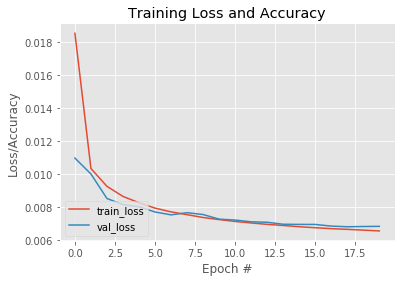

In [41]:
# construct a plot that plots and saves the training history
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [43]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoded").output)
print("[INFO] encoding images...")
features = encoder.predict(trainX)

[INFO] encoding images...


In [44]:
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}

In [50]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
    # initialize our list of results
    results = []
    # loop over our index
    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [51]:
test_features = encoder.predict(testX)

In [55]:
# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10, replace=False)

for i in queryIdxs:
    queryFeatures = test_features[i]
    results = perform_search(queryFeatures, data, maxResults=225)
    images = []
    
    for (d,j) in results:
        image = (trainX[j] * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)
        
    query = (testX[i] * 255).astype("uint8")
    cv2.imshow("Query", query)
    
    # build a montage from the results and display it
    montage = build_montages(images, (28, 28), (15, 15))[0]
    cv2.imshow("Results", montage)
    cv2.waitKey(0)